In [2]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [3]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log, feature_importance_all = classify.log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved


activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [4]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [5]:
print(mean_activity_r_1.shape)
print(mean_activity_r_2.shape)

print(trial_r_1)
print(trial_r_2)

(139, 3124)
(111, 3124)
[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]
[0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 18, 19, 19, 21, 22, 22, 23, 24, 25, 26, 26, 26, 26, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 35, 38, 40, 40, 41, 41, 41, 42, 43, 43, 44, 45, 45, 46, 47, 48, 48, 49, 49, 49, 49, 50, 50, 51, 52, 52, 52, 53, 53, 54, 55, 55, 55, 56, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58]


In [19]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations, exclude last reactivation for shape match
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)
    
    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_cs_1.shape, y_cs_1_clean.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))

(139, 3124) (139, 3124)
Processed Targets for CS_1:
{-1: 216563, 1: 217673}

Processed Targets for CS_2:
{-1: 173997, 1: 172767}


X_all shape: (250, 3124), y_all shape: (250, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.858 ± 0.047
Precision: 0.858
Recall:    0.861
F1-score:  0.856


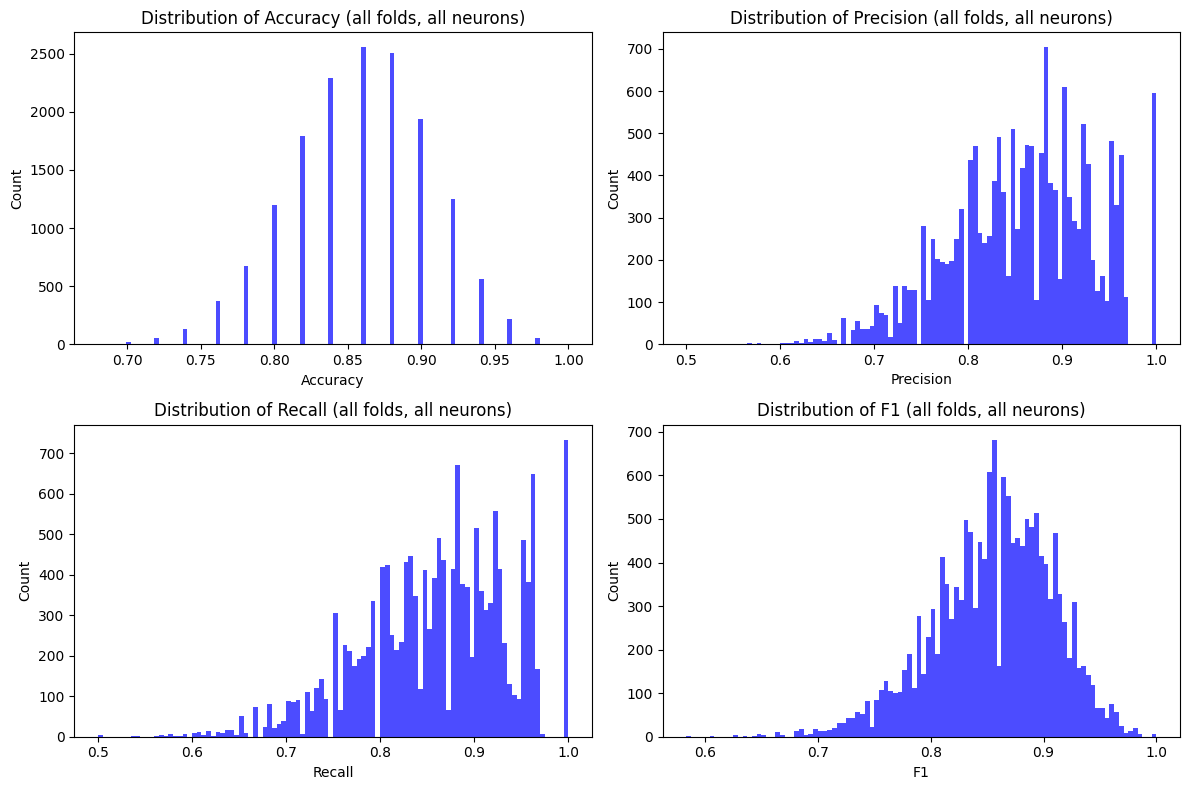

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from joblib import Parallel, delayed
from scipy.stats import ttest_ind



def evaluate_fold(model, X_train, X_test, y_train, y_test):
    """Trains the model and evaluates metrics for a single CV fold."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics for each output (neuron)
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_accuracies.append(accuracy_score(y_test_n, y_pred_n))
        fold_precisions.append(precision_score(y_test_n, y_pred_n, zero_division=0))
        fold_recalls.append(recall_score(y_test_n, y_pred_n, zero_division=0))
        fold_f1s.append(f1_score(y_test_n, y_pred_n, zero_division=0))

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s

def LR_model(X_all, y_all):
    print(f"X_all shape: {X_all.shape}, y_all shape: {y_all.shape}")

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Model initialization
    base_model = LogisticRegression(max_iter=1000, random_state=42, solver="lbfgs", 
                                    penalty="l2", class_weight="balanced")
    model_cv = MultiOutputClassifier(base_model)

    # Aggregate results
    all_results = Parallel(n_jobs=-1)(delayed(evaluate_fold)(
        model_cv, 
        X_all[train_idx], X_all[test_idx], 
        y_all[train_idx], y_all[test_idx]
    ) for train_idx, test_idx in kf.split(X_all))

    # Unpack results
    all_accuracies, all_precisions, all_recalls, all_f1s = zip(*all_results)
    all_accuracies = np.concatenate(all_accuracies)
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)
    all_f1s = np.concatenate(all_f1s)

    # Summary
    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:  {np.mean(all_accuracies):.3f} ± {np.std(all_accuracies):.3f}")
    print(f"Precision: {np.mean(all_precisions):.3f}")
    print(f"Recall:    {np.mean(all_recalls):.3f}")
    print(f"F1-score:  {np.mean(all_f1s):.3f}")

    metrics_dict = {
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1": all_f1s
    }

    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.7, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

LR_model(X_all, y_all)

In [39]:
def mean_reactivations_by_trial(mean_activity_r, trial_r, n_trials, fill_value=0):
   
    n_reactivations, n_neurons = mean_activity_r.shape
    
    # Accumulate sums of reactivation activity per trial
    trial_sums = np.zeros((n_trials, n_neurons), dtype=float)
    reactivation_counts = np.zeros(n_trials, dtype=int)
    
    for i in range(n_reactivations):
        trial_index = trial_r[i]
        trial_sums[trial_index] += mean_activity_r[i]
        reactivation_counts[trial_index] += 1

    # Compute mean, handling zero-reactivation trials
    trial_means = np.zeros_like(trial_sums)
    for t in range(n_trials):
        if reactivation_counts[t] > 0:
            trial_means[t] = trial_sums[t] / reactivation_counts[t]
        else:
            trial_means[t] = fill_value
    
    return trial_means

mean_mean_activity_r1 = mean_reactivations_by_trial(mean_activity_r_1, trial_r_1, n_trials=mean_activity_cs_1.shape[0])
print(mean_mean_activity_r1.shape)
mean_mean_activity_r2 = mean_reactivations_by_trial(mean_activity_r_2, trial_r_2, n_trials=mean_activity_cs_2.shape[0])
print(mean_mean_activity_r2.shape)


(68, 3124)
(60, 3124)


(68, 3124)
(60, 3124)
(126, 3124)
[[ 1 -1 -1 ... -1  1 -1]
 [ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (126, 3124), y_all shape: (126, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.520 ± 0.102
Precision: 0.518
Recall:    0.526
F1-score:  0.507


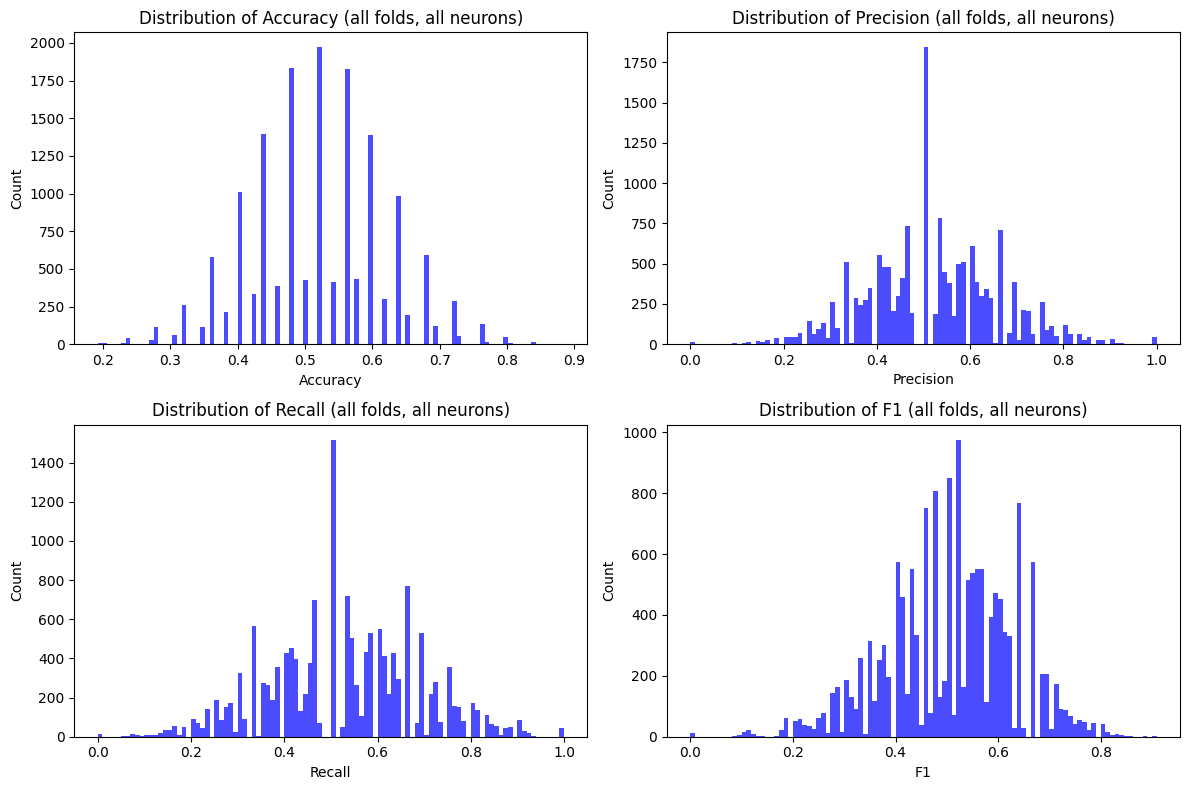

In [ ]:
X_1 = mean_mean_activity_r1 - mean_activity_cs_1
print(X_1.shape)
X_2 = mean_mean_activity_r2 - mean_activity_cs_2
print(X_2.shape)
x_all = np.concatenate([X_1[:-1, ], X_2[:-1, ]])
print(x_all.shape)

y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)

y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

LR_model(x_all, sign_changes)


[[ 1 -1 -1 ... -1  1 -1]
 [ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (126, 3124), y_all shape: (126, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.511 ± 0.104
Precision: 0.507
Recall:    0.518
F1-score:  0.497


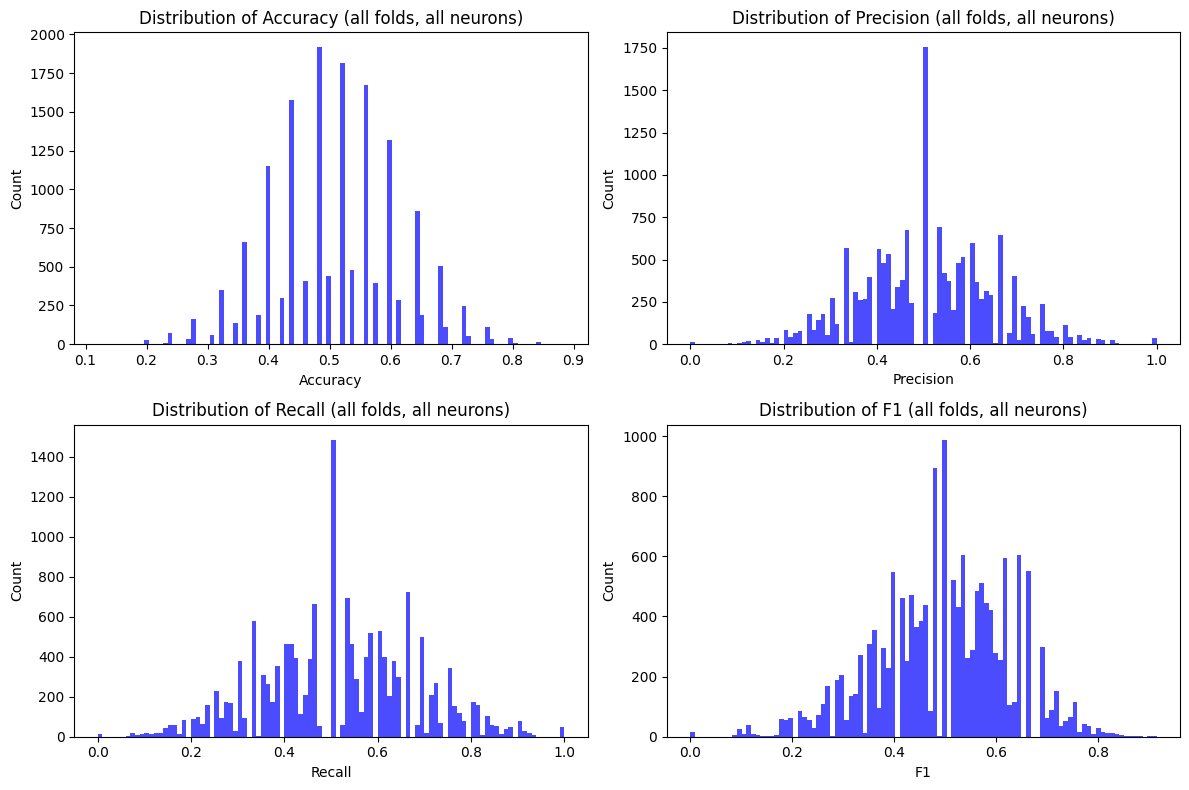

In [13]:
X_all = np.concatenate([mean_activity_cs_1[:-1, ], mean_activity_cs_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

LR_model(X_all, sign_changes)

X_all shape: (248, 3124), y_all shape: (248, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.384 ± 0.065
Precision: 0.380
Recall:    0.382
F1-score:  0.375


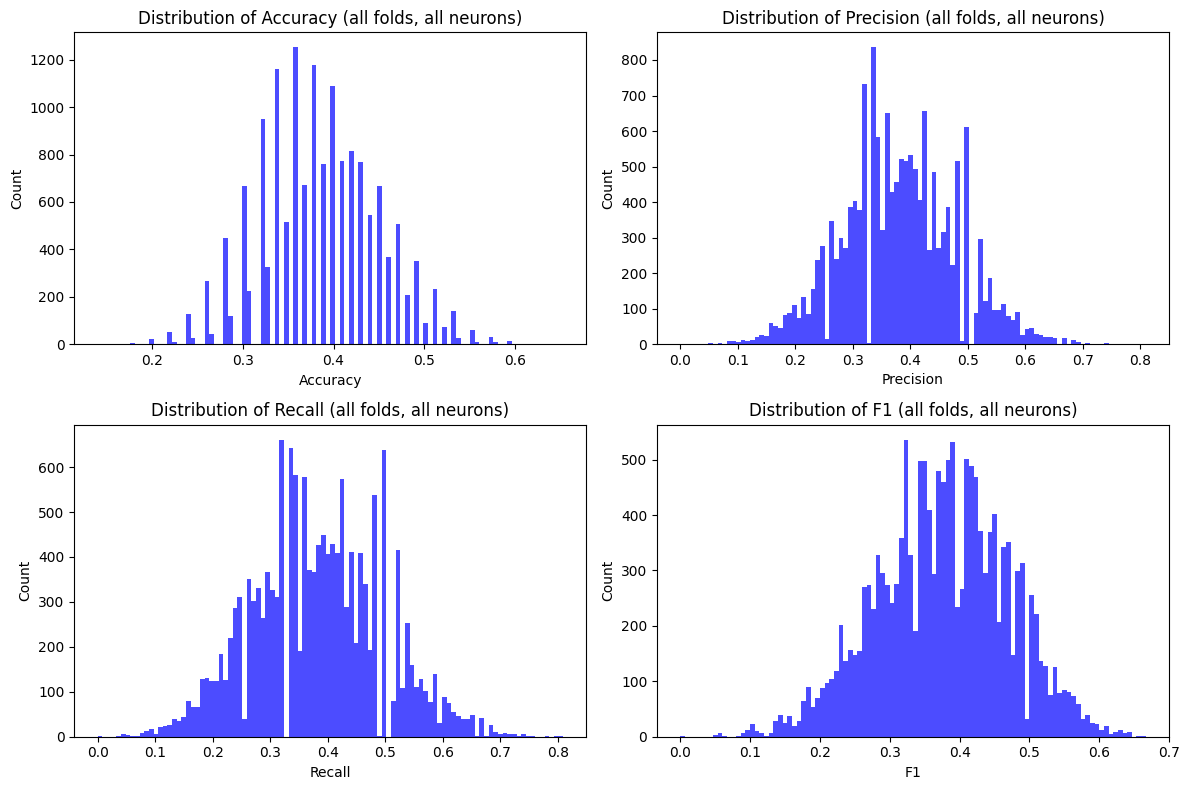

In [21]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(X_cs_1, axis=0)
X_cs_2_diff = np.diff(X_cs_2, axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean[:-1, ], y_cs_2_clean[:-1, ]]) 

LR_model(X_all, y_all)



X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.545 ± 0.071
Precision: 0.546
Recall:    0.540
F1-score:  0.535


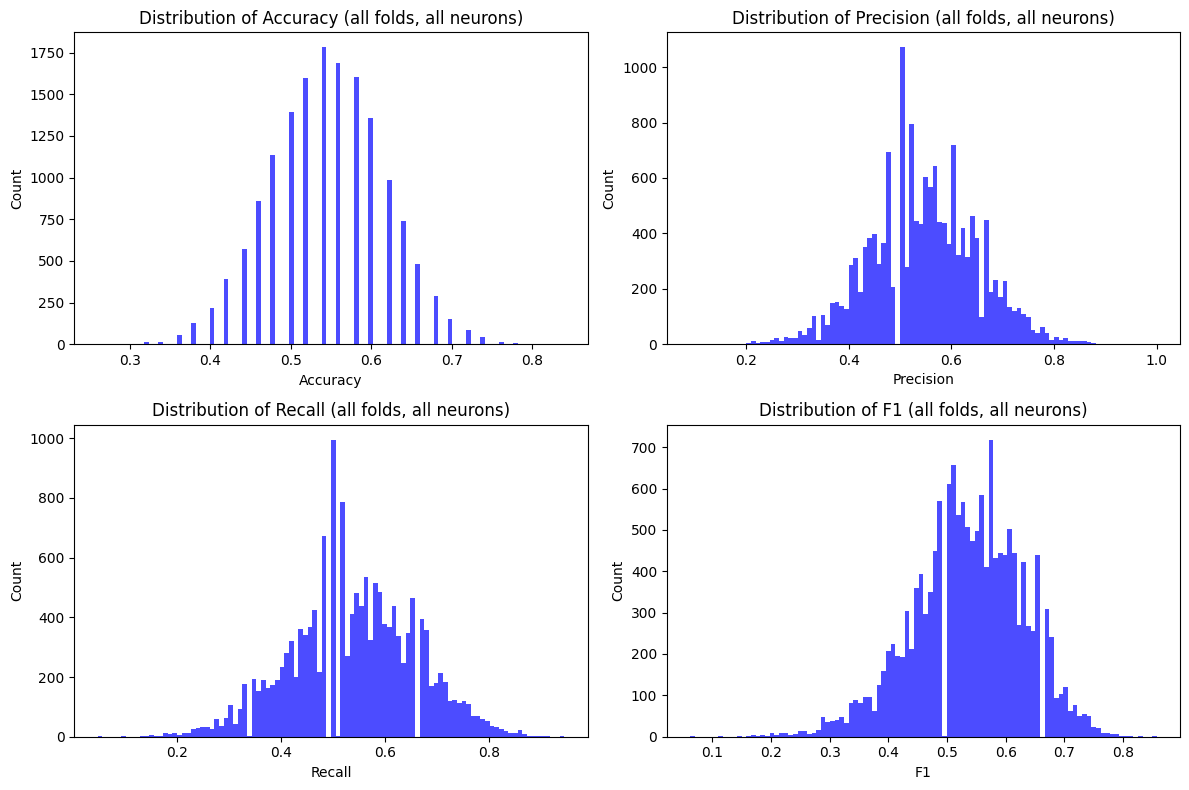

In [22]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(X_cs_1, axis=0)
X_cs_2_diff = np.diff(X_cs_2, axis=0)

X_all = np.concatenate([mean_activity_r_1, mean_activity_r_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

LR_model(X_all, y_all)



[[ 1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ...  1 -1 -1]
 [-1  1 -1 ... -1 -1 -1]
 ...
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1  1]]
X_all shape: (124, 3124), y_all shape: (124, 3124)



=== Cross-Validation Summary ===
Accuracy:  0.656 ± 0.095
Precision: 0.656
Recall:    0.660
F1-score:  0.646


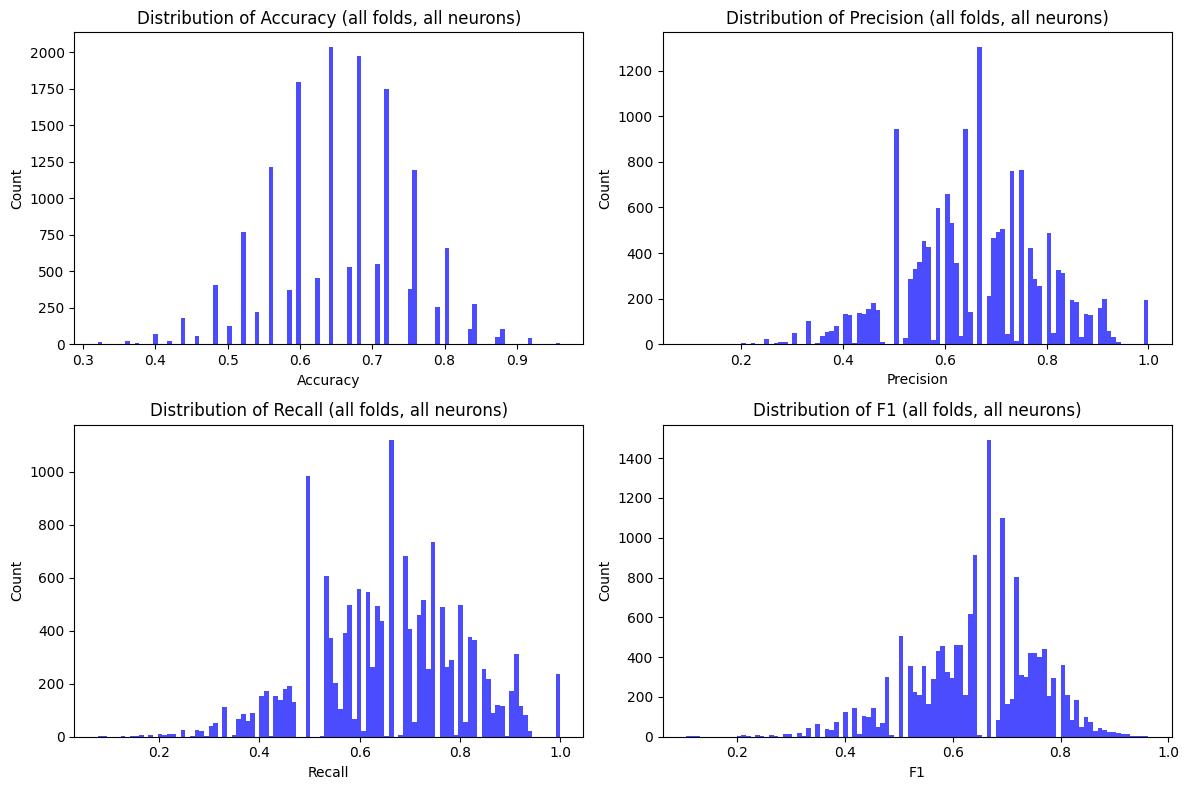

In [31]:
x_1 = np.diff(mean_activity_cs_1, axis= 0)
x_2 = np.diff(mean_activity_cs_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

LR_model(X_all, sign_changes)

In [32]:
arr1 = [3,4,6,7,3,7,8,2]
print(np.diff(arr1))

[ 1  2  1 -4  4  1 -6]
